# 'emPPCA' user instruction

In [1]:
from emPPCA import emPPCA

import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import pandas as pd
from sklearn.preprocessing import StandardScaler
from numpy import shape, isnan, nanmean, average, zeros, log, cov
from numpy.random import normal
from numpy.linalg import inv, det, eig
from numpy import trace as tr
from scipy.linalg import orth

---

## Load dataset
We take the data for pSCoPE Figure 4a as an example, this is comparing the outputs from the mass-spectrometry of macrophages with labels showing 'untreated' or 'LPS treated' [1]. <br/>
Below is part of the dataset, we consider 'XwGH05**' as different replicates, and 'celltype' is the class labels.

In [2]:
# Read data of size 373 * 1123
data = pd.read_csv('pSCoPE/processed.csv',index_col=0).T
# Read data guide containing the replicate information
guide = pd.read_csv('pSCoPE/guide.csv',index_col=0)
# Retain observations that appear in the data file only
guide = guide[guide.index.isin(data.index)]
guide

,RI,Raw.file,celltype,lcbatch,sortday,digest,cvm
id,,,,,,,
i10,Reporter.intensity.corrected.10,XwGH0500,untreated,B,B,C,0.353338
i102,Reporter.intensity.corrected.6,XwGH0526,LPS,B,B,C,0.291037
i103,Reporter.intensity.corrected.7,XwGH0526,LPS,B,B,C,0.302209
i104,Reporter.intensity.corrected.8,XwGH0526,LPS,B,B,C,0.345369
i105,Reporter.intensity.corrected.9,XwGH0526,LPS,B,B,C,0.295632
...,...,...,...,...,...,...,...
i91,Reporter.intensity.corrected.11,XwGH0513,untreated,B,B,C,0.308977
i92,Reporter.intensity.corrected.12,XwGH0513,untreated,B,B,C,0.312930
i93,Reporter.intensity.corrected.13,XwGH0513,untreated,B,B,C,0.370674


Below we are reconstructing the dataset into a list of numpy matrices (one replicate per matrix) according to the two dataframes above. <br/>
We also create the text labels and numerical labels for the replicate in the form of List[List[]].

In [3]:
id_rep = [] # Observation ids of each replicate
label_rep = [] # Observation labels of each replicate
Y_rep = [] # Data matrix of each replicate
R = 40 # Number of replicates
for i in range(R):
    id_rep.append(guide[guide['Raw.file'] == f'XwGH05{i:02d}'].index)
    label_rep.append(guide.loc[id_rep[i]]['celltype'].tolist())
    Y_rep.append(data.loc[id_rep[i]])
    
# Convert the labels into colour labels according to some color dictionary
label = [label_rep[i] for i in range(R)]
color_dict = {'untreated': 0, 'LPS': 1}
col = [[color_dict[i] for i in label[r]] for r in range(R)] 

It is important to standardise the input matrix before methods including PCA, PPCA. <br/>
Below we standardise and center the data matrices separately for each replicate.

In [4]:
scaler = StandardScaler()
Y = [scaler.fit_transform(df) for df in Y_rep]

---

## Create the 'emPPCA' instance
#### Parameters
`Y` &nbsp; Input data matrix of the $R$ replicates, $[R * (n_r * p)]$ <br/>
`q` &nbsp; Dimension of the principal subspace (i.e. the retained dimensions, or the dimension of the latent space) <br/> 
`textlabel` &nbsp; The text label for classes (or any object that represents the classes), $[R * [n_r]]$ <br/>
`label` &nbsp; The label for classes, starting from 0 to the number of classes minus one, $[R * [n_r]]$ <br/>
$q$ should be smaller than the rank for each residual variance $\sigma_r^2 > 0$, for example the pSCoPE dataset $q \leq 17$

#### Essential self variables
`model.X` &nbsp; Matrix $X$ in PPCA, low-dimensional representations, $[R * (n_r * q)]$ <br/>
`model.W` &nbsp; Matrix $W$ in PPCA, principal components matrix, $(p * q)$ <br/>
`model.sigma` &nbsp; Error term $\sigma^2$ in PPCA, variance unexplained for each replicate, $[R]$ <br/>

#### Other self variables
`model.Y` &nbsp; The input data matrix, $[R * (n_r * p)]$ <br/>
`model.p`,&nbsp; `model.q`,&nbsp; `model.n`,&nbsp; `model.R`

In [5]:
model = emPPCA(Y, q=5, textlabel=label_rep, label=col)

---

## Fit the instance
`model.fit()` method will run the EM algorithm to fit the input data matrix input in the instance. <br/>
The method also includes recovering the true principal components from the fitted principal subspace (the problem arises from the rotational invariance matrix $R$ for the MLE $W$ explained in [2]) <br/>

#### Parameters
`tol` &nbsp; Tolerance for the convergence of ELBO in the EM algorithm, default $10^{-6}$ <br/>
`max_iter` &nbsp; The limiting maximum number of EM iterations, default $1000$ <br/>
`seed` &nbsp; Random seed for initialization of the EM algorithm, default None

#### New self variables
`model.objective` &nbsp; A record of ELBO being optimized in the EM algorithm, $[R]$ <br/>
`model.recon` &nbsp; Reconstruction of $Y$ if consider PPCA as an autoencoder, $(\sum n_r * p)$ <br/>
`model.Y_imp` &nbsp; Input data matrix with missing values imputed by EM algorithm, $[R * (n_r * p)]$ <br/>
`model.eigvals` &nbsp; Variance explained by each principal component, in decreasing order, $[R]$ <br/>
`model.X`, &nbsp; `model.W`, &nbsp; `model.sigma` &nbsp; will be updated after the method


In [6]:
model.fit()

EM algorithm converged with 218 iterations; with relative change 9.784836106792845e-07.


---

## Other Methods

### Log-likelihood (EM-ELBO) plot
The method shows the convergence of EM algorithm in the aspect from log-likelihood.

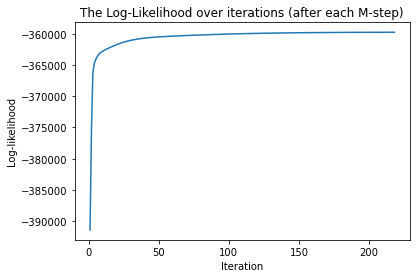

In [7]:
model.ll_plot()

### Variance-unexplained plot
The method produces a line chart showing the residual variances (in percentage) in the increasing order. <br/>
There could particularly be issues with the highest a few replicates, for example higher technical noise.

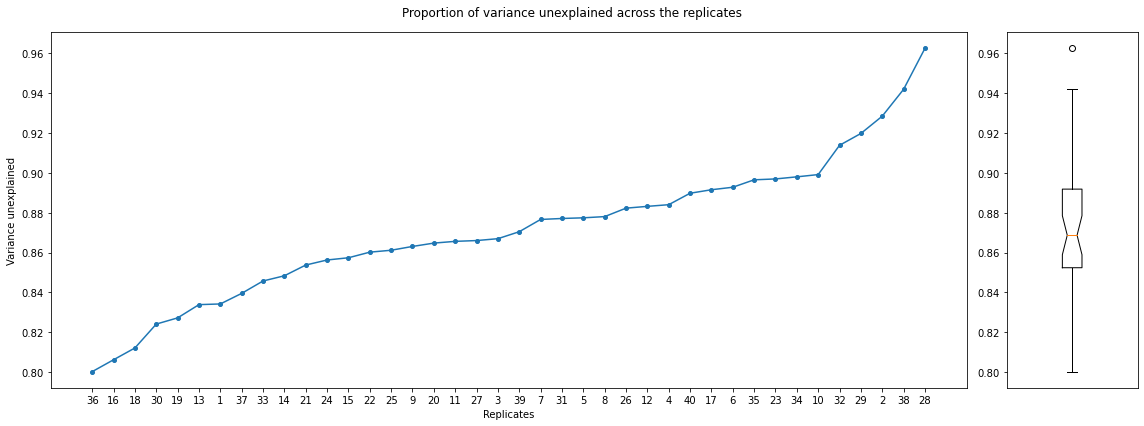

In [8]:
model.var_plot()

### Replicate-wise plot for X
The method compares two dimensions of the low-dimensional representations $X$. <br/>
`pcs` &nbsp; The PCs being visualized, defaultly PC1 versus PC2. <br/>
`reps` &nbsp; The replicates being included for visualization, defaultly all replicates. <br/>
`label` &nbsp; The color labels for dataset with full replicates, defaultly None. <br/>
`NN` &nbsp; Whether or not plot the 1-NearestNeighbor line fitted under the full dataset for reference. <br/>
`lims` &nbsp; Specifying the limits for scattering, of both dimensions. <br/>
`separate` &nbsp; Whether or not put the legend box outside the figure. <br/>
The replicate ids here are naturally starting from 1 instead of 0.

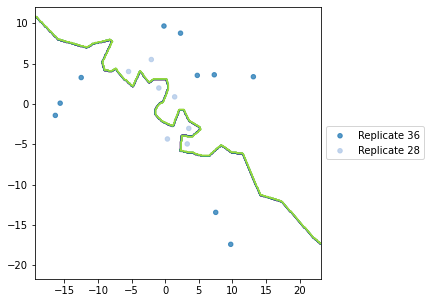

In [9]:
# Distinguish points by the replicate ids
model.X_plot(pcs=[0,1], reps=[36, 28], compare='replicate', NN=True, lims=None, separate_legend=True)

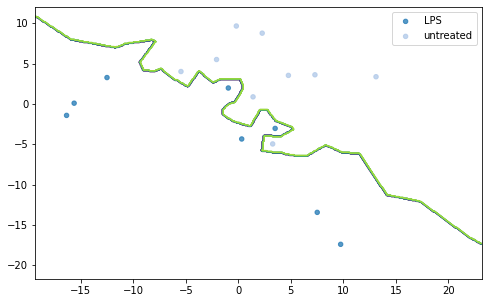

In [10]:
# Distinguish points by the class labels
model.X_plot(pcs=[0,1], reps=[36, 28], compare='class', NN=True, lims=None, separate_legend=False)

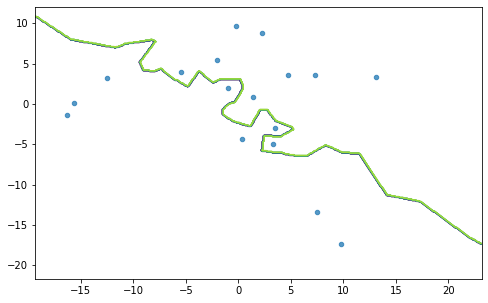

In [11]:
# Pose no color differences on the points
model.X_plot(pcs=[0,1], reps=[36, 28], NN=True, lims=None, separate_legend=False)

### Reconstruction uncertainty plot (*)
This method visualizes the proportion of reconstructed data points within
the range spanned by some multiplies of the residual standard error around the true datapoints. <br/>
NOT SUITABLE for high dimensional data as PPCA is a relatively simple method and primarily not for reconstruction.

In [12]:
# model.recon_uncertainty()

---

## References

###### [1] &nbsp; Huffman, R. G., Leduc, A., Wichmann, C., Di Gioia, M., Borriello, F., Specht, H., ... & Slavov, N. (2023). Prioritized mass spectrometry increases the depth, sensitivity and data completeness of single-cell proteomics. Nature methods, 20(5), 714-722.

###### [2] &nbsp; Tipping, M. E., & Bishop, C. M. (1999). Probabilistic principal component analysis. Journal of the Royal Statistical Society Series B: Statistical Methodology, 61(3), 611-622.